In [203]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix,precision_score,classification_report

In [204]:
sample_df = pd.read_csv('Docree Dataset\DOCREE_SAMPLE_SUBMISSION_FINALE.csv')
train_df = pd.read_csv('Docree Dataset\Doceree-HCP_Train.csv',encoding='latin-1')
test_df = pd.read_csv('Docree Dataset\Doceree-HCP_Test.csv',encoding='latin-1')
train_df = train_df.dropna(subset=['IS_HCP'])

In [205]:
train_df.IS_HCP = train_df.IS_HCP.astype('int')
train_df = train_df.dropna(subset=['USERPLATFORMUID','USERAGENT'])
df = pd.concat([train_df,test_df])
df=df.drop(['TAXONOMY','CHANNELTYPE'],axis=1)

In [206]:
numerical_cols = [cols for cols in df.columns if df[cols].dtype in ['int64','float64']]
numerical_cols.remove('IS_HCP')
df['USERZIPCODE_flag'] = df['USERZIPCODE'].isnull().astype(int)
df[numerical_cols] =  df[numerical_cols].fillna(df[numerical_cols].mode().iloc[0])

In [207]:
categorical_cols = [cols for cols in df.columns if df[cols].dtype == 'object']
mapping = df.groupby('USERZIPCODE')['USERCITY'].apply(lambda x: x.mode()[0] if len(x.mode()) > 0 else None).to_dict()
df['USERCITY'] = df['USERCITY'].fillna(df['USERZIPCODE'].map(mapping))
df['USERCITY_flag'] = df['USERCITY'].isnull().astype(int)
df[categorical_cols]=df[categorical_cols].fillna(df[categorical_cols].mode().iloc[0])

In [208]:
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

In [209]:
df_train = df[~np.isnan(df['IS_HCP'])]
df_test = df[np.isnan(df['IS_HCP'])]

In [210]:
y = df_train['IS_HCP']
X = df_train.drop(['IS_HCP','ID'],axis=1).copy()

In [211]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split

In [212]:
smote = SMOTETomek(sampling_strategy=0.7, random_state=1)

# Apply SMOTE to over-sample the minority classes
X_resampled, y_resampled = smote.fit_resample(X, y)

In [213]:
X.shape

(113930, 12)

In [214]:
X_resampled.shape

(132773, 12)

In [215]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=41)

In [216]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier

rfc = RandomForestClassifier(n_estimators=50, random_state=1)
bc = BaggingClassifier(n_estimators=50, random_state=1, max_samples=0.9, max_features=0.9)
etc = ExtraTreesClassifier(n_estimators=50, random_state=1)
xgb = XGBClassifier(n_estimators=50,random_state=1,learning_rate=0.1,max_depth=25)

clfs = { 
    'RF': rfc, 
    'BgC': bc, 
    'ETC': etc,
    'xgb':xgb
}

def train_classifier(clf,X_train,y_train,X_test,y_test):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred,zero_division=1,average='weighted')
    
    return accuracy,precision

In [217]:
accuracy_scores = []
precision_scores = []

for name,clf in clfs.items():
    
    current_accuracy,current_precision = train_classifier(clf, X_train,y_train,X_test,y_test)
    
    print("For ",name)
    print("Accuracy - ",current_accuracy)
    print("Precision - ",current_precision)
    
    
    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)

For  RF
Accuracy -  0.9907738655620411
Precision -  0.9907907678616288
For  BgC
Accuracy -  0.9918282809263792
Precision -  0.991849614008432
For  ETC
Accuracy -  0.9880248540764451
Precision -  0.9880350990465453
For  xgb
Accuracy -  0.9910751270947091
Precision -  0.9910973697322626


In [218]:
performance_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy':accuracy_scores,'Precision':precision_scores}).sort_values('Accuracy',ascending=False)
performance_df

,Algorithm,Accuracy,Precision
1,BgC,0.991828,0.991850
3,xgb,0.991075,0.991097
0,RF,0.990774,0.990791
2,ETC,0.988025,0.988035


In [219]:
from sklearn.ensemble import StackingClassifier
estimators=[('BgC', bc), ('etc', etc), ('xgb', xgb),('rfc',rfc)]
final_estimator=RandomForestClassifier(n_estimators=50,random_state=1)
clf = StackingClassifier(estimators=estimators, final_estimator=final_estimator)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy",accuracy_score(y_test,y_pred))
print("Precision",precision_score(y_test,y_pred))

Accuracy 0.9932592732065524
Precision 0.9922663997816396


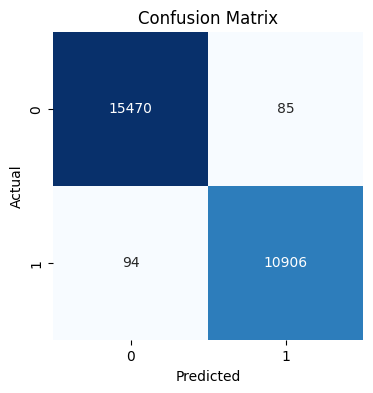

In [220]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [221]:
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     15555
         1.0       0.99      0.99      0.99     11000

    accuracy                           0.99     26555
   macro avg       0.99      0.99      0.99     26555
weighted avg       0.99      0.99      0.99     26555



In [222]:
df_test_processing = df_test.drop(['IS_HCP','ID'],axis=1).copy()
df_test['IS_HCP']=clf.predict(df_test_processing)
df_train['TAXONOMY'] = train_df['TAXONOMY']
df_train.loc[train_df['IS_HCP'] == 0, 'TAXONOMY'] = '0'
df_train['TAXONOMY']=df_train['TAXONOMY'].fillna(df_train['TAXONOMY'].mode().iloc[0])
# df_train = df_train.dropna(subset=['TAXONOMY'])

C:\Users\ASUS\AppData\Local\Temp\ipykernel_10072\1342227909.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['IS_HCP']=clf.predict(df_test_processing)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_10072\1342227909.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['TAXONOMY'] = train_df['TAXONOMY']
C:\Users\ASUS\AppData\Local\Temp\ipykernel_10072\1342227909.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

In [223]:
taxonomy_counts = df_train['TAXONOMY'].value_counts()

# Step 2: Get the values that appear more than once
values_to_keep = taxonomy_counts[taxonomy_counts > 20].index.tolist()

# Step 3: Filter the DataFrame to keep only the rows with values that appear more than once
df_filtered = df_train[df_train['TAXONOMY'].isin(values_to_keep)]

# Optional: If you want to reset the index of the filtered DataFrame
df_filtered.reset_index(drop=True, inplace=True)

In [224]:
df_train=df_filtered.copy()

In [225]:
y = df_train['TAXONOMY']
X = df_train.drop(['TAXONOMY','ID'],axis=1).copy()


In [226]:
X.shape

(113231, 13)

In [227]:
y.value_counts()

TAXONOMY
0             81621
2084P0800X     7928
2084N0400X     6621
207Q00000X     3997
207R00000X     3190
              ...  
363LA2100X       24
2081P2900X       22
163WP0808X       22
183500000X       22
207QS0010X       21
Name: count, Length: 72, dtype: int64

In [228]:
from collections import Counter

In [229]:
class_counts = Counter(y)

# Calculate the target class with the maximum count (majority class)
majority_class = max(class_counts, key=class_counts.get)

# Calculate the desired ratio for each class (in this example, we set minority classes to be twice the size of the majority class)
sampling_strategy = {cls: 8000 for cls in class_counts if cls != majority_class}

In [230]:
smote = SMOTETomek(sampling_strategy=sampling_strategy,random_state=1)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [231]:
X_train,X_test,y_train,y_test = train_test_split(X_resampled, y_resampled,test_size=0.2,random_state=1)

In [232]:
X_train.shape

(490740, 13)

In [233]:
y_train.value_counts().values

array([64262,  6445,  6444,  6396,  6365,  6363,  6354,  6342,  6317,
        6293,  6290,  6285,  6284,  6275,  6259,  6254,  6249,  6236,
        6229,  6225,  6222,  6219,  6218,  6214,  6194,  6187,  6180,
        6171,  6164,  6161,  6148,  6143,  6141,  6135,  6130,  6120,
        6116,  6098,  6073,  6070,  6059,  6044,  6029,  6016,  6001,
        5995,  5986,  5980,  5975,  5971,  5968,  5947,  5939,  5839,
        5831,  5823,  5766,  5744,  5713,  5653,  5647,  5638,  5569,
        5553,  5523,  5481,  5457,  5453,  5350,  5215,  5173,  5131],
      dtype=int64)

In [234]:
clfs = {
    'RF': rfc, 
    'BgC': bc, 
    'ETC': etc
}

In [235]:
accuracy_scores = []
precision_scores = []

for name,clf in clfs.items():
    
    current_accuracy,current_precision = train_classifier(clf, X_train,y_train,X_test,y_test)
    
    print("For ",name)
    print("Accuracy - ",current_accuracy)
    print("Precision - ",current_precision)
    
    
    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)

For  RF
Accuracy -  0.9811305375555284
Precision -  0.980269498673975
For  BgC
Accuracy -  0.9803969515425683
Precision -  0.9795758631013393
For  ETC
Accuracy -  0.9785711374658679
Precision -  0.9775850806370209


In [236]:
performance_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy':accuracy_scores,'Precision':precision_scores}).sort_values('Accuracy',ascending=False)
performance_df

,Algorithm,Accuracy,Precision
0,RF,0.981131,0.980269
1,BgC,0.980397,0.979576
2,ETC,0.978571,0.977585


In [237]:
from sklearn.ensemble import VotingClassifier
estimators=[('BgC', bc), ('etc', etc),('rfc',rfc)]

voting_clf = VotingClassifier(estimators=estimators, voting='soft')

# Fit the voting ensemble
voting_clf.fit(X_train, y_train)

# Make predictions
y_pred = voting_clf.predict(X_test)

# Calculate metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred,zero_division=1,average='weighted'))

Accuracy: 0.9833638994172067
Precision: 0.9826765238509635


In [238]:
df_test_processing = df_test.drop(columns=['ID'],axis=1).copy()
df_test['TAXONOMY'] =  voting_clf.predict(df_test_processing)
final=df_test[['ID','TAXONOMY']]
final['TAXONOMY'] = final['TAXONOMY'].replace('0',-1)
final.to_csv('final_submission.csv',index=False)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_10072\1212591999.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['TAXONOMY'] =  voting_clf.predict(df_test_processing)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_10072\1212591999.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final['TAXONOMY'] = final['TAXONOMY'].replace('0',-1)
